In [3]:
import puz
import glob
import os
import random

from pprint import pprint
from grid_generator_latest import (generate_grid, 
                                   create_crossword_grid, 
                                   add_black_squares, 
                                   returnJSON, 
                                   visualize_crossword_image)
from Utils import puz_to_json

#### Testing generator-grid with grid nums from Ujjwal

In [4]:
grid_size = 11
max_iters = 600
b_factor = 6

rows = cols = grid_size
no_ran_iters = max_iters

if grid_size != 4:
    while no_ran_iters == max_iters:
        crossword_grid = create_crossword_grid(rows, cols)
        crossword_grid, no_ran_iters, symmetry = add_black_squares(crossword_grid, max_iters, black_factor = b_factor)
else:
    crossword_grid = create_crossword_grid(rows, cols)
    crossword_grid, no_ran_iters, symmetry = add_black_squares(crossword_grid, max_iters, black_factor = b_factor)

In [5]:
json_data = returnJSON(crossword_grid, rows, cols)
grid_nums = json_data['gridnums']
across_nums = json_data['across_nums']
down_nums = json_data['down_nums']

### Working around with the British-Style Crosswords

In [6]:
puz_dir_path = './British-Style Crosswords Puz'

puz_filepath_list = glob.glob(os.path.join(puz_dir_path, '*.puz'))
selected_puz_filepath = random.choice(puz_filepath_list)

In [7]:
def get_compatible_grid_structure(puz_filepath):
    '''
        Get grid_structure, and number of rows and columns from a give puz file path, 
        in the format suitable for getting gridnumbering from Ujjwal's algorithm
    '''
    grid_json_data = puz_to_json(puz_filepath)
    rows, cols = grid_json_data['metadata']['rows'], grid_json_data['metadata']['cols']
    ori_grid_ = grid_json_data['grid']

    grid_structure = []
    for i in range(rows):
        row = []
        for j in range(cols):
            if isinstance(ori_grid_[i][j], list):
                row.append(' ')
            else:
                row.append('.')
        grid_structure.append(row)
    return grid_structure, rows, cols

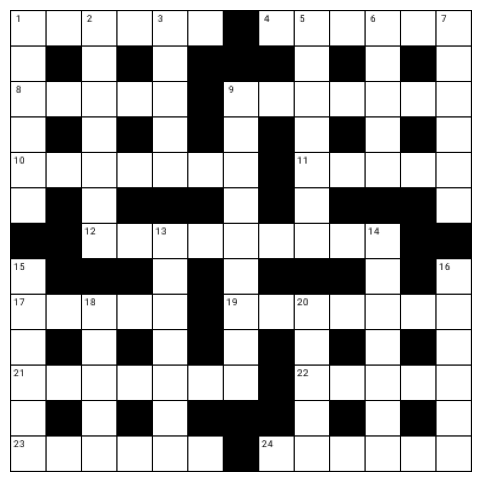

In [17]:
grid_structure, rows, cols = get_compatible_grid_structure(selected_puz_filepath)
formatted_grid_json = returnJSON(grid_structure, rows, cols)
grid_nums = formatted_grid_json['gridnums']
across_nums = formatted_grid_json['across_nums']
down_nums = formatted_grid_json['down_nums']
reshaped_grid = [grid_nums[i:i+rows] for i in range(0, len(grid_nums), rows)]

visualize_crossword_image(grid_structure, reshaped_grid)

### Grid-Variables corresponding to the Grid Nums

In [11]:
class Variable():

    ACROSS = "across"
    DOWN = "down"

    def __init__(self, i, j, direction, length):
        """Create a new variable with starting point, direction, and length."""
        self.i = i
        self.j = j
        self.direction = direction
        self.length = length
        self.cells = []
        for k in range(self.length):
            self.cells.append(
                (self.i + (k if self.direction == Variable.DOWN else 0),
                 self.j + (k if self.direction == Variable.ACROSS else 0))
            )

    def __hash__(self):
        return hash((self.i, self.j, self.direction, self.length))

    def __eq__(self, other):
        return (
            (self.i == other.i) and
            (self.j == other.j) and
            (self.direction == other.direction) and
            (self.length == other.length)
        )

    def __str__(self):
        return f"({self.i}, {self.j}) {self.direction} : {self.length}"

    def __repr__(self):
        direction = repr(self.direction)
        return f"Variable({self.i}, {self.j}, {direction}, {self.length})"

class Crossword():
    def __init__(self, grid, black_cell_str = '', words_file = None, file_path = True):
        self.structure = []
        self.height = len(grid) # the number of rows in the grid
        self.width = len(grid[0]) # the number of columns in the grid
        self.black_cell_str = black_cell_str
        for i in range(len(grid)):
            row = []
            for j in range(len(grid[0])):
                if grid[i][j] == black_cell_str: #black cells
                    row.append(False)
                else:
                    row.append(True) #white cells
            self.structure.append(row)
        
        if words_file is not None:
            if not file_path:
                self.words = [word.upper() for word in words_file]

            else:
                # Save vocabulary list
                with open(words_file) as f:
                    self.words = set(f.read().upper().splitlines()) # to remove all the duplicates
                    self.words = list(self.words)
                    for _ in range(5):
                        random.shuffle(self.words)
                self.words = set(self.words)

        # Determine variable set
        self.variables = set()

        for i in range(self.height):
            for j in range(self.width):
                # Vertical words
                starts_word = (
                    self.structure[i][j]
                    and (i == 0 or not self.structure[i - 1][j])
                )
                if starts_word:
                    length = 1
                    for k in range(i + 1, self.height):
                        if self.structure[k][j]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.DOWN,
                            length=length
                        ))

                # Horizontal words
                starts_word = (
                    self.structure[i][j]
                    and (j == 0 or not self.structure[i][j - 1])
                )
                if starts_word:
                    length = 1
                    for k in range(j + 1, self.width):
                        if self.structure[i][k]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.ACROSS,
                            length=length
                        ))

        # Compute overlaps for each word
        # For any pair of variables v1, v2, their overlap is either:
        #    None, if the two variables do not overlap; or
        #    (i, j), where v1's ith character overlaps v2's jth character
        self.overlaps = dict()
        self.overlaps_positions = dict()
        for v1 in self.variables:
            for v2 in self.variables:
                if v1 == v2:
                    continue
                cells1 = v1.cells
                cells2 = v2.cells
                intersection = set(cells1).intersection(cells2)
                if not intersection:
                    self.overlaps[v1, v2] = None
                else:
                    intersection = intersection.pop()
                    self.overlaps[v1, v2] = (
                        cells1.index(intersection),
                        cells2.index(intersection)
                    )
                    for cell in cells1:
                        for cell_ in cells2:
                            if cell == cell_:
                                self.overlaps_positions[v1, v2] = cell
                                break

    def neighbors(self, var):
        """Given a variable, return set of overlapping variables."""
        return set(
            v for v in self.variables
            if v != var and self.overlaps[v, var]
        )

In [61]:
variables = Crossword(grid_structure, black_cell_str = '.').variables

across_variables = []
down_variables = []

for var in variables:
    if var.direction == 'across':
        across_variables.append(reshaped_grid[var.i][var.j])
    elif var.direction == 'down':
        down_variables.append(reshaped_grid[var.i][var.j])

In [41]:
if len(across_variables) != len(across_nums):
    print("Number of Across slots doesn't match!!!")
    for grid_n in set(across_nums) - set(across_variables):
        print(f"Across - {grid_n}")
elif len(down_variables) != len(down_nums):
    print("Number of Down slots doesn't match!!!")
    for grid_n in set(down_nums) - set(down_variables):
        print(f"Down - {grid_n}")

Number of Across slots doesn't match!!!
Across - 16
Across - 15


This test here, verifies that the Variables from the Crossword Class doesn't match with the number of slots from the grid-numbering modules. So, the above code needs to be made compatible and suitable for the British-Style crosswords too.

In [51]:
def get_answer_length(grid, start_cell_pos, direction, black_cell_str):
    '''
        Get the required answer length for a direction starting cell position, related grid ans direction
    '''
    i, j = start_cell_pos
    rows, cols = len(grid), len(grid[0])
    
    answer_len = 0
    if direction == 'across':
        for k in range(j, cols):
            if grid[i][k] != black_cell_str:
                answer_len += 1
            else:
                break
    elif direction == 'down':
        for k in range(i, rows):
            if grid[k][j] != black_cell_str:
                answer_len += 1
            else:
                break
    return answer_len

In [55]:
variables_list = set()
for i in range(rows):
    for j in range(cols):
        if reshaped_grid[i][j] != 0: # if no black cells is present then 
            grid_num = reshaped_grid[i][j]
            if grid_num in across_nums:
                ans_len = get_answer_length(grid_structure, (i, j), 'across', '.')
                variables_list.add(Variable(i = i, j = j, direction = 'across', length = ans_len))
            if grid_num in down_nums:
                ans_len = get_answer_length(grid_structure, (i, j), 'down', '.')
                variables_list.add(Variable(i = i, j = j, direction = 'down', length = ans_len))
            

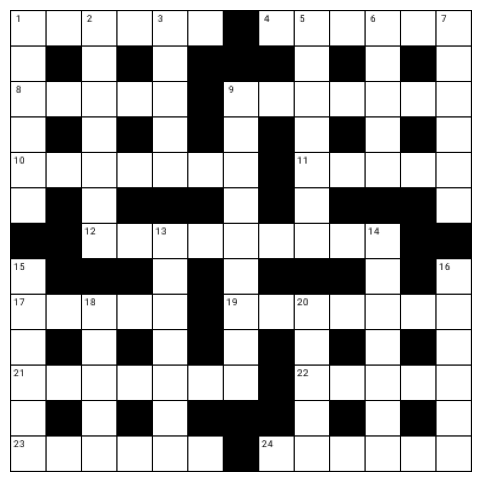

{Variable(0, 0, 'across', 6),
 Variable(0, 0, 'down', 6),
 Variable(0, 10, 'down', 5),
 Variable(0, 12, 'down', 6),
 Variable(0, 2, 'down', 7),
 Variable(0, 4, 'down', 5),
 Variable(0, 7, 'across', 6),
 Variable(0, 8, 'down', 7),
 Variable(10, 0, 'across', 7),
 Variable(10, 8, 'across', 5),
 Variable(12, 0, 'across', 6),
 Variable(12, 7, 'across', 6),
 Variable(2, 0, 'across', 5),
 Variable(2, 6, 'across', 7),
 Variable(2, 6, 'down', 9),
 Variable(4, 0, 'across', 7),
 Variable(4, 8, 'across', 5),
 Variable(6, 10, 'down', 7),
 Variable(6, 2, 'across', 9),
 Variable(6, 4, 'down', 7),
 Variable(7, 0, 'across', 1),
 Variable(7, 0, 'down', 6),
 Variable(7, 12, 'across', 1),
 Variable(7, 12, 'down', 6),
 Variable(8, 0, 'across', 5),
 Variable(8, 2, 'down', 5),
 Variable(8, 6, 'across', 7),
 Variable(8, 8, 'down', 5)}

In [62]:
visualize_crossword_image(grid_structure, reshaped_grid)
variables_list

{Variable(0, 0, 'across', 6),
 Variable(0, 0, 'down', 6),
 Variable(0, 10, 'down', 5),
 Variable(0, 12, 'down', 6),
 Variable(0, 2, 'down', 7),
 Variable(0, 4, 'down', 5),
 Variable(0, 7, 'across', 6),
 Variable(0, 8, 'down', 7),
 Variable(10, 0, 'across', 7),
 Variable(10, 8, 'across', 5),
 Variable(12, 0, 'across', 6),
 Variable(12, 7, 'across', 6),
 Variable(2, 0, 'across', 5),
 Variable(2, 6, 'across', 7),
 Variable(2, 6, 'down', 9),
 Variable(4, 0, 'across', 7),
 Variable(4, 8, 'across', 5),
 Variable(6, 10, 'down', 7),
 Variable(6, 2, 'across', 9),
 Variable(6, 4, 'down', 7),
 Variable(7, 0, 'down', 6),
 Variable(7, 12, 'down', 6),
 Variable(8, 0, 'across', 5),
 Variable(8, 2, 'down', 5),
 Variable(8, 6, 'across', 7),
 Variable(8, 8, 'down', 5)}

#### Lets analyze this British-Crosswords grid

In [66]:
puz_dir_path = './British-Style Crosswords Puz'

puz_filepath_list = glob.glob(os.path.join(puz_dir_path, '*.puz'))

for puz_filepath in puz_filepath_list:
    json_data = puz_to_json(puz_filepath)
    rows, cols = json_data['metadata']['rows'], json_data['metadata']['cols']
    
    print(rows, cols)

13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 13
13 1